In [284]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [285]:
def pipe_flatten_names(column):    
    return '|'.join([x['name'] for x in column])

In [286]:
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries',
                   'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
        df[column] = df[column].apply(pipe_flatten_names)
    return df, json_columns

In [287]:
data, json_columns = load_tmdb_movies('tmdb_5000_movies.csv')

In [288]:
data.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,Ingenious Film Partners|Twentieth Century Fox ...,United States of America|United Kingdom,2009-12-10,2787965087,162.0,English|Español,Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,Walt Disney Pictures|Jerry Bruckheimer Films|S...,United States of America,2007-05-19,961000000,169.0,English,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|mi6|bri...,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,Columbia Pictures|Danjaq|B24,United Kingdom|United States of America,2015-10-26,880674609,148.0,Français|English|Español|Italiano|Deutsch,Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,Legendary Pictures|Warner Bros.|DC Entertainme...,United States of America,2012-07-16,1084939099,165.0,English,Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,United States of America,2012-03-07,284139100,132.0,English,Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [289]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null 

In [290]:
def get_year(date):
    return date.year

In [291]:
def split_object(df, column):
    set_column = set()
    for row in data[column]:
        for j in row.split('|'):       
            set_column.add(j)  
    return set_column

def one_hot_genre_encoding(df, set_column, column):    
    for obj in set_column:
        labels = []
        if obj:
            for i in range(len(df)):
                if obj in df.loc[i][column]:
                    labels.append(1)
                else:
                    labels.append(0)           
            df[obj] = labels
        else:
            continue
    return df

def label_encoding(df, column):
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    return df

In [292]:
def prepare_data(df):  
    
    remove_cols = ['genres', 'homepage', 'keywords', 'spoken_languages', 'overview', 'original_title',
                  'tagline', 'release_date', 'status','title','production_countries', 'production_companies', 
                   'original_language']
    df['year'] = df['release_date'].apply(get_year)
    genres = split_object(data, 'genres')
    df = one_hot_genre_encoding(df, genres, 'genres')
    df = df.loc[df['status'] == 'Released']
    df.drop(remove_cols, axis=1, inplace=True)   
    return df

In [293]:
data = prepare_data(data)

C:\Users\chigrai_au\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [294]:
def get_genre_info_by_year(df, genres, year_condition):
    genre_pop_means = []    
    for g in genres:
        clean_df = df.loc[year_condition & (df[g] == 1), 'popularity']
        popular_mean = clean_df.mean()
        genre_pop_means.append(popular_mean)
    genre_data = pd.DataFrame({'genre': genres, 'mean_popularity': genre_pop_means}).\
                                sort_values('mean_popularity', ascending=False)
    genre_data.loc[genre_data['mean_popularity'].isna(), 'mean_popularity'] = 0
    return genre_data

In [295]:
genres = data.columns[7:]
before_1990 = get_genre_info_by_year(data, genres, data['year'] <= 1990)
after_1990 = get_genre_info_by_year(data, genres, data['year'] > 1990)
before_1990.set_index('genre', inplace=True)
after_1990.set_index('genre', inplace=True)

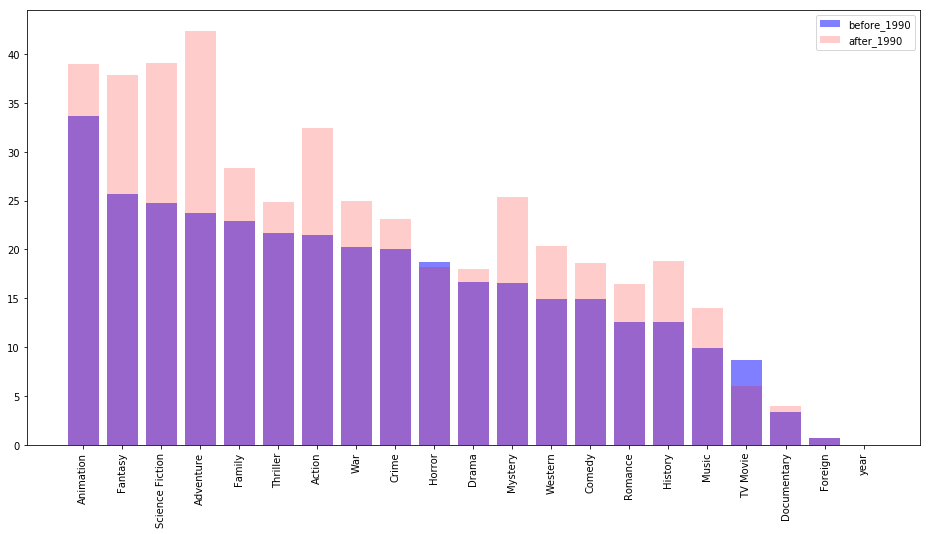

In [296]:
plt.figure(figsize=(16,8))
plt.bar(before_1990.index, before_1990 ['mean_popularity'], color='b', alpha=0.5, label='before_1990')
plt.bar(after_1990.index, after_1990 ['mean_popularity'], color='r', alpha=0.2, label='after_1990')
plt.xticks(rotation='90')
plt.legend();

In [297]:
best_popularity = np.abs(before_1990 - after_1990).sort_values(by='mean_popularity', ascending=False)[:5]
best_popularity

,mean_popularity
genre,
Adventure,18.702967
Science Fiction,14.313250
Fantasy,12.138430
Action,10.874172
Mystery,8.731739


In [298]:
from scipy import stats

In [299]:
def variance_analysis(y, y1, y2, alpha=0.05):
    y1_mean = y1.mean()
    y2_mean = y2.mean()
    y_mean  = y.mean()
    n1 = y1.shape[0]
    n2 = y2.shape[0]
    print(f'среднее y1 = {round(y1_mean, 2)}\n'
          f'среднее y2 = {round(y2_mean, 2)}')
    S2_F = n1 * (y1_mean - y_mean) ** 2 + n2 * (y2_mean - y_mean) ** 2
    S2_res = ((y1  - y1_mean) ** 2).sum() + ((y2 - y2_mean) ** 2).sum() 
   
    k = 2
    n = n1 + n2
    k1 = k - 1
    k2 = n - k
    sigma2_F = S2_F / k1
    sigma2_res = S2_res / k2        
    T = sigma2_F / sigma2_res
    F_crit = stats.f.ppf(1 - alpha, k1, k2)

    if T > F_crit:
        print(f'T {round(T, 2)} > F_crit {round(F_crit, 2)}, Разница средних статистически значима')
    else:
        print(f'T {round(T, 2)} <= F_crit {round(F_crit, 2)}, Разница средних статистически незначима')    

In [300]:
y1 = data.loc[(data['Adventure'] == 1) & (data['year'] <= 1990), 'vote_average']
y2 = data.loc[(data['Adventure'] == 1) & (data['year'] > 1990), 'vote_average']
y =  data.loc[(data['Adventure'] == 1), 'vote_average']
variance_analysis(y, y1, y2)

среднее y1 = 6.43
среднее y2 = 6.1
T 14.75 > F_crit 3.85, Разница средних статистически значима


In [301]:
y1 = data.loc[(data['Adventure'] == 1) & (data['year'] <= 1990), 'revenue']
y2 = data.loc[(data['Adventure'] == 1) & (data['year'] > 1990), 'revenue']
y =  data.loc[(data['Adventure'] == 1), 'revenue']
variance_analysis(y, y1, y2)

среднее y1 = 100704144.84
среднее y2 = 230514323.12
T 23.67 > F_crit 3.85, Разница средних статистически значима


In [302]:
data = data.loc[(data['revenue'] > 0) & (data['budget'] > 0)]
data.corr()['revenue'].sort_values(ascending=False)

revenue            1.000000
vote_count         0.756177
budget             0.705353
popularity         0.602186
Adventure          0.344104
runtime            0.233073
Fantasy            0.216269
Animation          0.210431
Family             0.200386
Action             0.187926
vote_average       0.187659
year               0.147604
Science Fiction    0.142215
id                 0.030131
War               -0.021624
Foreign           -0.025559
Mystery           -0.030833
Thriller          -0.037593
Western           -0.039949
Music             -0.042764
Comedy            -0.049745
History           -0.050481
Documentary       -0.055921
Romance           -0.071691
Crime             -0.078603
Horror            -0.097334
Drama             -0.189108
TV Movie                NaN
Name: revenue, dtype: float64

In [303]:
data = data[['revenue', 'budget']]

In [111]:
stats = data.groupby(['Adventure', 'year'], as_index=False)['vote_count', 'popularity'].mean().\
        rename(columns={'vote_count': 'mean_vote_count', 'popularity': 'mean_popularity'})
r_columns = ['revenue', 'budget', 'Adventure', 'mean_vote_count', 'mean_popularity']
adventure_data = pd.merge(data, stats , on=['Adventure', 'year'], how='left')[r_columns]
adventure_data = adventure_data.loc[adventure_data['revenue'] != 0]

In [224]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [304]:
scaler = StandardScaler()
data = scaler.fit_transform(data)
X = data[:,1:]
y = data[:, 0]

In [314]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [315]:
pred = model.predict(X_test)
r2_score(y_test, pred)

0.5458997006366986

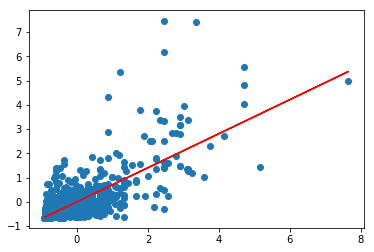

In [316]:
plt.scatter(X_test, y_test)
plt.plot(X_test, pred, color='r')